# Exploratory Data Analysis
It's 
so feature engineering  
review predictor (host description, room description, sentiment analysis, word complexity, description length)  
AH. subdivide your listings first based on price. because you need to compare apples with apples

base on the interquartile range  
acceptable  
above average  
great  
exceptional  
see the distribution, then turn into a classification problem  

what else goes into a review score?  
did le-son use review and description together for topic modelling?  
price predictor with seasonality component  
accuracy classifier - class imbalance - use same features, but this is just a feature separate from the others  
NIP OUTLIERS(quartile range, fixed value), NUMERICIZE, NORMALIZE  
did le-son collapse some of the repeat columns?  
surprised that review score did not play a bigger role in the score  
perhaps it has more to do with occupancy  
can do AB testing - photo quality, lower price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer, PowerTransformer

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 110)

lapath = 'data/losangeles-13feb/listings (1).csv'
pathname = 'data/sf-12feb/listings (1).csv'
nypath = 'data/newyork-12feb/listings (1).csv'

df = pd.read_csv(pathname)
print('sf', df.shape)
df.info()


sf (8587, 106)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8587 entries, 0 to 8586
Columns: 106 entries, id to reviews_per_month
dtypes: float64(20), int64(23), object(63)
memory usage: 6.9+ MB


/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#we drop columns that don't have bearing on the customer
neededcolumns = ['id', 'listing_url', 'name', 'summary', 'space', 'description',
                 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
                 'host_id', 'host_url', 'host_since', 'host_about', 'host_response_time', 
                 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
                'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 
                'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 
                'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
                'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_rating',
                'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture',
                'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']
#what is this 'adjusted' nonsense. whtever don't include it
#how is availability used?

df = df[neededcolumns]

# df.info()
#normalize (why though - because we want it to correspond and predict natural phenomena) 
#numericalize - because your computer deals best with that (convert into categoricals, or one hot encode)
# nip off outliers they can seriously skew your model - usually use points more or less than 4 quartiles

#2 other things you can do for general hygiene
# create buckets for small data bits
# fill null values with the mean or some default value

#create host experience - today() minus host since
#responsiveness = time to respond * rate
#host neighborhood - IF same as neighborhood - make it binary
#neighborhood has to be dummified


In [3]:
# import pandas_profiling

# report = pandas_profiling.ProfileReport(df, html = {'style': {'full_width': True}})
# report

In [4]:
#Some of these things have no direct (e.g ID) or 
#limited effect (e.g almost all host require guest verification) on the actual product
#so they will be excluded first
excludefrommodel = ['id', 'listing_url', 'require_guest_phone_verification', 
                    'latitude', 'longitude', 'is_business_travel_ready', 'maximum_nights', 'minimum_nights',
                    'host_id', 'host_url', 'host_has_profile_pic', 'host_listings_count']

fornlp = ['access', 'description', 'host_about', 'house_rules', 'interaction', 'name', 'neighborhood_overview',
         'notes', 'space', 'summary', 'transit']


df.drop(labels = (excludefrommodel + fornlp), axis = 1, inplace = True)

In [5]:
#now we do our ftre engrg
import re

def dollarformat(x):
    '''
    convert currency strings into interger amounts
    removes $ , and . 
    converts str into int
    '''
    try: 
        return round(int(re.sub('[$,,,.]', '', x))/100,1)
    except:
        return x


df['cleaning_fee'] = df['cleaning_fee'].map(lambda x: dollarformat(x))
df['extra_people'] = df['extra_people'].map(lambda x: dollarformat(x))
df['price'] = df['price'].map(lambda x: dollarformat(x))
df['security_deposit'] = df['security_deposit'].map(lambda x: dollarformat(x))
df['weekly_price'] = df['weekly_price'].map(lambda x: dollarformat(x))
# you will still have to deal with the null values
#how do you want to deal with that?


In [6]:
#converting strings to date time
df.first_review = pd.to_datetime(df.first_review)
df.host_since = pd.to_datetime(df.host_since)
df.last_review = pd.to_datetime(df.last_review)

df['listing_age'] = pd.datetime.today() - df.first_review
df['host_age'] = pd.datetime.today() - df.host_since

/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 414.,  229.,  341.,  418.,  225.,  822.,  610.,  780.,  735.,
        1973.]),
 array([-2.23042914, -1.90196632, -1.5735035 , -1.24504067, -0.91657785,
        -0.58811503, -0.25965221,  0.06881061,  0.39727343,  0.72573625,
         1.05419907]),
 <a list of 10 Patch objects>)

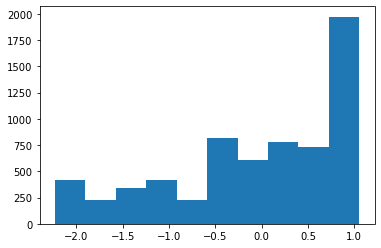

In [107]:
def percentage(x):
    '''
    convert % strings into interger amounts
    removes % , and . 
    converts str into int
    '''
    try: 
        return round(int(re.sub('[%,,,.]', '', x))/100,2)
    except:
        return x

df.host_acceptance_rate = df.host_acceptance_rate.map(lambda x: percentage(x))
df.host_response_rate = df.host_response_rate.map(lambda x: percentage(x))

def responsetime(x):
    if x == 'a few days or more':
        return int(1)
    elif x == 'within a day':
        return int(2)
    elif x == 'within a few hours':
        return int(3)
    elif x == 'within an hour':
        return int(4)
    else:
        return x
    
df.host_response_time = df.host_response_time.map(lambda x : responsetime(x))


def truefalse(x):
    if x == 't':
        return 1
    if x == 'f':
        return 0
    else:
        return x

df.host_is_superhost = df.host_is_superhost.map(lambda x : truefalse(x))
df.instant_bookable = df.instant_bookable.map(lambda x : truefalse(x))
df.host_identity_verified = df.host_identity_verified.map(lambda x : truefalse(x))
df.require_guest_profile_picture = df.require_guest_profile_picture.map(lambda x : truefalse(x))
# df.info()
df.cancellation_policy.unique()

def cancels(x):
    if x == 'super_strict_60':
        return int(1)
    elif x == 'super_strict_30':
        return int(2)
    elif x == 'strict':
        #Full refund for cancellations made within 48 hours of booking, 
        #if the check-in date is at least 14 days away. 
        #50% refund for cancellations made at least 7 days before check-in. 
        #No refunds for cancellations made within 7 days of check-in
        return int(3)
    elif x == 'strict_14_with_grace_period':
        return int(4)
    elif x == 'luxury_moderate':
        return int(5)
    elif x == 'moderate':
        return int(5)
    elif x == 'flexible':
        #full refund 1 day before arrival
        return int(6)
    else:
        return x
#nag it what's the diff between luxury moderate
    
df.cancellation_policy = df.cancellation_policy.map(lambda x: cancels(x))

def bedtype(x):
    if x == 'Real Bed':
        return 1
    else:
        return 0
df.bed_type = df.bed_type.map(lambda x: bedtype(x))

def room(x):
    if x == 'Entire home/apt':
        return 4
    elif x == 'Private room':
        return 3
    elif x  == 'Hotel room':
        return 2
    elif x == 'Shared room':
        return 1
    else:
        return x
df.room_type = df.room_type.map(lambda x: room(x))

df['adjusted'] = df['review_scores_rating']

qt = QuantileTransformer(output_distribution = 'normal')
pt = PowerTransformer(method = 'box-cox')

df['adjusted'] = pt.fit_transform(df['adjusted'].values.reshape(-1,1))
#wwww further consider removing scores that have 3 reviews or less!

#TESTING CHUNK
plt.hist(df.adjusted)
# plt.xticks(rotation = 45, fontsize = 15)




## MODELING

In [109]:
from sklearn.model_selection import train_test_split

#wwwww need to come back to this later
#include all the needed columns from ftre engrng
simpleregtodrop = ['neighbourhood_cleansed', 'host_neighbourhood', 'zipcode', 'property_type', 'amenities', 'weekly_price', 'host_since', 'first_review', 'last_review', 'listing_age', 'host_age', 'review_scores_rating']
smalld = df.drop(labels = simpleregtodrop, axis =1)

#there's a minority of values where price == 0 so we will drop them out
#we can impute values for our independent/x variables, but not our y variables
smalld = smalld[smalld['price'] != 0]

#wwwww need to come back to this later
smalldf = smalld.fillna(value = 0)

# smalldf['intercept'] = 1
#wwww how does setting one of the x variables to 1 cause the model to intercept the y?

X = smalldf.drop(labels = 'price', axis = 1)

y = smalldf['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [110]:
#wwwww
#add visualizations
y_train = np.log(y_train)



/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


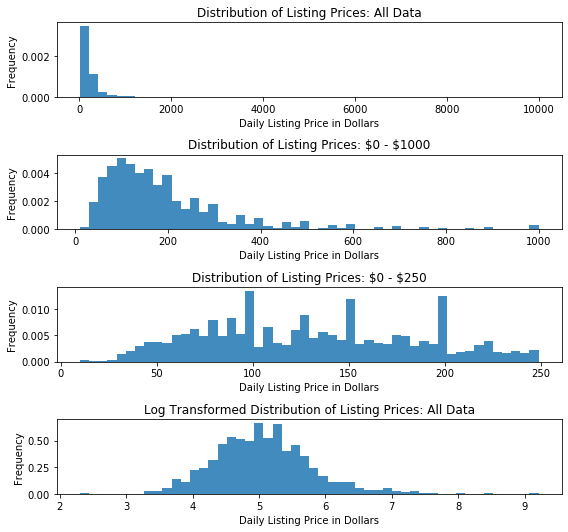

In [111]:
def plot_hist(n, titles, ranges):
    """
    Quick helper function to plot histograms
    """
    fig, ax = plt.subplots(n, figsize = (8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 50, normed = 1, alpha = 0.85)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Daily Listing Price in Dollars")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot histograms of price distribution
plot_hist(4, 
          ['Distribution of Listing Prices: All Data', 'Distribution of Listing Prices: \$0 - \$1000', 
               'Distribution of Listing Prices: \$0 - \$250','Log Transformed Distribution of Listing Prices: All Data'], 
          [y, y[y <= 1000], y[y < 250],y_train])



/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0, 0.5, 'Actual Price')

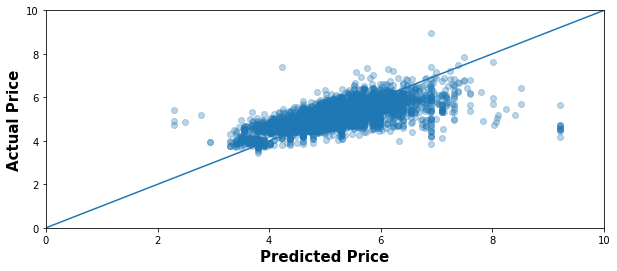

In [112]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()

test_set_pred = fit.predict(sm.add_constant(X_train))

plt.figure(figsize=(10,4))
plt.scatter(y_train, test_set_pred, alpha= .3)
plt.plot(np.linspace(0,10000000,100), np.linspace(0,10000000,100))
plt.ylim(0, 10)
plt.xlim(0, 10)
# print('r2 score is:', r2_score(y, test_set_pred))
# print('mean absolute error(MAE) is:', mae(y_test, test_set_pred))
plt.xlabel('Predicted Price', fontsize = 15, fontname = 'Helvetica', fontweight = 'bold')
plt.ylabel('Actual Price', fontsize = 15, fontname = 'Arial', 
           fontweight = 'bold')

In [113]:


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

fivesplits = KFold(n_splits = 5, shuffle = True, random_state = 7)

#we'll also do a cross validation to see model performance on top of ordinary least squares
np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv = fivesplits, scoring = 'r2'))

#okay not too bad.. we'll continue on
#https://sukhbinder.wordpress.com/2018/08/07/cross-validation-score-with-statsmodels/
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     279.6
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:20:50   Log-Likelihood:                -5418.1
No. Observations:                6868   AIC:                         1.088e+04
Df Residuals:                    6845   BIC:                         1.104e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.4886      0.063     55.324      0.000       3.365       3.612
host_response_time                 0.0046      0.014      0.333      0.739      -0.022       0.031
host_response_rate                -0.1094      0.051     -2.132      0.033      -0.210      -0.009
host_acceptance_rate              -0.1079      0.029     -3.719      0.000      -0.165      -0.051
host_is_superhost                  0.0761      0.015      4.935      0.000       0.046       0.106
host_identity_verified             0.0095      0.014      0.665      0.506      -0.019       0.038
room_type                          0.3120      0.012     26.564      0.000       0.289       0.335
accommodates                       0.1355      0.007     19.695      0.000       0.122       0.149
bathrooms                         -0.0166      0.008     -2.054      0.040      -0.032      -0.001
bedrooms                           0.1507      0.012     12.434      0.000       0.127       0.174
beds                              -0.0429      0.010     -4.370      0.000      -0.062      -0.024
bed_type                       -5.467e-16   5.61e-17     -9.738      0.000   -6.57e-16   -4.37e-16
security_deposit                4.347e-05   1.04e-05      4.161      0.000     2.3e-05    6.39e-05
cleaning_fee                      -0.0001      0.000     -0.980      0.327      -0.000       0.000
guests_included                    0.0130      0.006      2.041      0.041       0.001       0.025
extra_people                       0.0006      0.000      2.520      0.012       0.000       0.001
number_of_reviews                 -0.0003      0.000     -2.084      0.037      -0.001   -1.57e-05
number_of_reviews_ltm              0.0010      0.001      1.344      0.179      -0.000       0.002
instant_bookable                   0.0483      0.015      3.312      0.001       0.020       0.077
cancellation_policy                0.0090      0.008      1.121      0.262      -0.007       0.025
require_guest_profile_picture     -0.0870      0.035     -2.473      0.013      -0.156      -0.018
calculated_host_listings_count     0.0006      0.000      4.250      0.000       0.000       0.001
reviews_per_month                 -0.0203      0.008     -2.584      0.010      -0.036      -0.005
adjusted                           0.0780      0.008      9.964      0.000       0.063       0.093
==============================================================================
Omnibus:                     2947.776   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36701.393
Skew:                           1.712   Prob(JB):                         0.00
Kurtosis:                      13.795   Cond. No.                     4.96e+19
===============

In [12]:
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
#first element of sol series is the pair with the bigest correlation
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
sol

NameError: name 'corr_matrix' is not defined

### Helper Functions
We will create generalizable functions to clean our data:  
- outlier detection (data must be continuous)
- filling null values
- normalize and transform variables

In [ ]:
#need to clean security deposit
#transform amenities

#LVA bucketing:
#host response rate
#host acceptance rate

### Feature Engineering
We create meaningful features from existing ones

/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([147., 203., 266., 366., 224., 822., 609., 780., 735., 973.]),
 array([-2.22904864, -1.90072387, -1.5723991 , -1.24407433, -0.91574956,
        -0.58742479, -0.25910002,  0.06922476,  0.39754953,  0.7258743 ,
         1.05419907]),
 <a list of 10 Patch objects>)

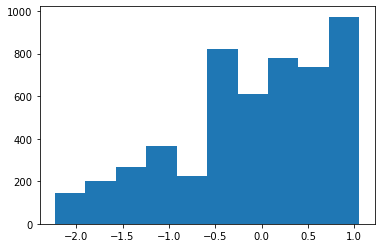

In [108]:


#can try a log then boxcox, but unlikely to yield much results. because this is not to do with magnitude
# it's got to do with frequency

minthreshold = 91.5    
df['adjusted'] = df['review_scores_rating']

qt = QuantileTransformer(output_distribution = 'normal')
pt = PowerTransformer(method = 'box-cox')

df['adjusted'] = pt.fit_transform(df['adjusted'].values.reshape(-1,1))
# df['adjusted'] = df['adjusted'] ** 2
# df['adjusted'] = pt.fit_transform(df['adjusted'].values.reshape(-1,1))
# df['adjusted'] = df['adjusted'] ** 2
# df['adjusted'] = pt.fit_transform(df['adjusted'].values.reshape(-1,1))

#WWWWWW can we apply box-cox twice?

df['adjusted'].describe()
# plt.hist(sf[sf['number_of_reviews'] > 10]['review_scores_rating'])

plt.hist(df[df['number_of_reviews'] > 3]['adjusted'])

#so this is an interesting transformation, because we want to determine, exceptionally good
#and i suppose exceptionally bad

#ANYHOW, FORGET THESE REVIEWS. MOVE ON

In [ ]:
x = df[(df['review_scores_rating'] <79) & (df['number_of_reviews'] > 7)].sort_values(by = 'review_scores_rating', ascending = False)
test = df[(df['adjusted'] > 4) & (df['number_of_reviews'] > 7)].sort_values(by = 'adjusted', ascending = False)
test.head()